# Analysis of performance of different MICE implementations in Python

In this notebook, several implementations of Multiple Imputation using Chained Equations (MICE) are evaluated and a benchmark of the results on accuracy (loss) and speed is performed.

The algorithm's implementations used in this notebook use a few iterations for convergence with a total of 5 iterations due to a time budget and are the following:

1. Value by value imputation over a set number of iterations (Vanila MICE)
2. Column by column imputation over a set number of iterations  (Fast MICE)
3. Value by value imputation in the first iteration and column by column for the remaining iterations (Slow-Fast MICE)
4. Column by Column imputation in all iteration except the last one where value by value imputation is used for the remaining iterations (Fast-Slow MICE)

The datasets used for benchmarking the algorithms are available on **Scikit-Learn's** dataset module:

- boston house-prices (regression)
- iris (classification)
- diabetes  (regression)
- wine  (classification)
- breast_cancer (classification)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

## Load datasets for benchmark

In [3]:
# import datasets
from sklearn.datasets import (
    load_boston,
    load_iris,
    load_diabetes,
    load_wine,
    load_breast_cancer
)

In [4]:
def load_dataset(load_dataset_fn, target_name='target'):
    """Loads the dataset to a pandas DataFrame."""
    dataset = load_dataset_fn()
    features_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
    if len(dataset.target.shape) == 1:
        target_df = pd.DataFrame(dataset.target, columns=[target_name])
    else:
        target_df = pd.DataFrame(data=dataset.target, columns=dataset.target_names).add_prefix(target_name + '_')
    return features_df, target_df

def show_sample(features_df, target_df):
    return pd.concat([features_df, target_df], axis=1).head(5)

In [5]:
# Load boston house prices dataset
boston_features_df, boston_target_df = load_dataset(load_boston, target_name='median_value')
show_sample(boston_features_df, boston_target_df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,median_value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# Load iris dataset
iris_features_df, iris_target_df = load_dataset(load_iris, target_name='class')
iris_target_df = iris_target_df.astype('category')
show_sample(iris_features_df, iris_target_df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
# Load diabetes dataset
diabetes_features_df, diabetes_target_df = load_dataset(load_diabetes, target_name='disease_measure')
show_sample(diabetes_features_df, diabetes_target_df)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease_measure
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [8]:
# Load wine dataset
wine_features_df, wine_target_df = load_dataset(load_wine, target_name='class')
wine_target_df = wine_target_df.astype('category')
show_sample(wine_features_df, wine_target_df)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [9]:
# Load breast cancer dataset
breast_cancer_features_df, breast_cancer_target_df = load_dataset(load_breast_cancer, target_name='class')
breast_cancer_target_df = breast_cancer_target_df.astype('category')
show_sample(breast_cancer_features_df, breast_cancer_target_df)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [10]:
data = {
    "boston": [boston_features_df, boston_target_df],
    "iris": [iris_features_df, iris_target_df],
    "diabetes": [diabetes_features_df, diabetes_target_df],
    "wine": [wine_features_df, wine_target_df],
    "breast_cancer": [breast_cancer_features_df, breast_cancer_target_df]
}

## Algorithms

The following MICE algorithms use LightGBM models for classification / regression. Due to its speed, accuracy and multi-thread capabilities, it provides great performance at a reasonable time for this benchmark.

The methods are divided into four different types: 

1. **Vanila MICE**: value by value imputation over a set number of iterations
2. **Fast MICE**: Column by column imputation over a set number of iterations
3. **Slow-Fast MICE**: Value by value imputation in the first iteration and column by column for the remaining iterations
4. **Fast-Slow MICE**: Column by Column imputation in all iterations except the last one which uses value by value imputation for the remaining iterations

> Note: methods 3 and 4 use a combination of **Vanila MICE** and **Fast Mice** for their computations.

In [11]:
from time import time
from tqdm import tqdm
import lightgbm as lgb
from pandas.api.types import is_categorical_dtype, is_numeric_dtype
from sklearn.metrics import mean_squared_error

class BaseMICE:
    """Base class for the MICE implementation."""
    
    def __init__(self, max_iter=10):
        self.max_iter = max_iter
    
    def fill_missing_values(self, df):
        """Fills the missing values of a pandas DataFrame.
        
        Parameters
        ----------
        df : pandas.DataFrame
            Input data with missing values (nans).
            
        Returns
        -------
        pandas.DataFrame
            DataFrame with imputed missing values.
        """
        nan_ids = np.argwhere(df.isna().values).tolist()
        df_imputed = self.impute_initial_mean_or_mode(df)
        iter_results = []
        for iter in range(self.max_iter):
            df_imputed = self.transform(df_imputed, nan_ids, iter)
        return df_imputed
    
    def benchmark(self, df_original, df_missing, drop_columns_loss=None):
        """Benchmarks the fill method for missing values.
        
        Parameters
        ----------
        df_original : pandas.DataFrame
            Original data.
        df_missing : pandas.DataFrame
            Input data with missing values (nans).
        drop_columns_loss : list, optional
            Drop columns in the result DataFrame when 
            computing the loss.
            
        Returns
        -------
        pandas.DataFrame
            DataFrame with imputed missing values.
        """
        columns_missing = df_missing.isna().sum()
        columns_missing = columns_missing[columns_missing > 0]
        nan_ids = np.argwhere(df_missing.isna().values).tolist()
        df_imputed = self.impute_initial_mean_or_mode(df_missing)
        self.df_mean = df_imputed.copy()
        
        iter_results = []
        for iter in range(self.max_iter):
            time_start = time()
            df_imputed = self.transform(df_imputed, columns_missing, nan_ids, iter)
            time_stop = time() - time_start
            if drop_columns_loss:
                loss = self.compute_loss(df_original.drop(columns=drop_columns_loss, axis=1), 
                                         df_imputed.drop(columns=drop_columns_loss, axis=1))
            else:
                loss = self.compute_loss(df_original, df_imputed)
            iter_results.append({
                "iter": iter,
                "time_seconds": time_stop, 
                "loss": loss
            })
        return iter_results
    
    def benchmark_mean_loss(self, df_original, df_missing, drop_columns_loss=None):
        """Computes the same iterations as benchmark() but only for the of the mean imputation method."""
        time_start = time()
        df_imputed = self.impute_initial_mean_or_mode(df_missing)
        time_stop = time() - time_start
        
        iter_results = []
        for iter in range(self.max_iter):
            if drop_columns_loss:
                loss = self.compute_loss(df_original.drop(columns=drop_columns_loss, axis=1), 
                                         df_imputed.drop(columns=drop_columns_loss, axis=1))
            else:
                loss = self.compute_loss(df_original, df_imputed)
            iter_results.append({
                "iter": iter,
                "time_seconds": time_stop, 
                "loss": loss
            })
        return iter_results
    
    def get_model(self, target):
        if is_numeric_dtype(target):
            model = lgb.LGBMRegressor()
        else:
            model = lgb.LGBMClassifier()
        return model
    
    def compute_loss(self, original_df, filled_df):
        """Computes the difference between the original and filled DataFrames."""
        return mean_squared_error(original_df, filled_df)
    
    def impute_initial_mean_or_mode(self, df):
        df_new = df.copy()
        for column in df:
            if is_numeric_dtype(df[column]):
                df_new[column] = df_new[column].fillna(df_new[column].mean())
            else:
                df_new[column] = df_new[column].fillna(df_new[column].mode())
        return df_new
    
    def transform(self, df, nan_ids):
        pass

In [12]:
class VanilaMICE(BaseMICE):
    """MICE implementation using value by value imputation."""
    
    method_name = "Vanila MICE"
    
    def transform(self, df: pd.DataFrame, columns_missing: list, nan_ids: list, iter_id: int):
        random_ids = np.random.permutation(len(nan_ids)).tolist()
        for id in tqdm(random_ids, desc=f"{self.method_name}: Iter {iter_id + 1} / {self.max_iter}", position=0):
            # Setup data
            row_id, col_id = nan_ids[id]
            target_column_name = df.columns[col_id]
            X = df.drop(columns=[target_column_name], axis=1)
            X = pd.get_dummies(X, drop_first=True)
            y = df[target_column_name]
            
            # Fit model
            model = self.get_model(y).fit(X.drop(index=row_id), y.drop(index=row_id))
            
            # Predict value
            df.iloc[row_id, col_id] = model.predict(X.iloc[row_id:row_id + 1, :])
        return df

In [13]:
class FastMICE(BaseMICE):
    """MICE implementation using column by column imputation."""
    
    method_name = "Fast MICE"
    
    def transform(self, df: pd.DataFrame, columns_missing: list, nan_ids: list, iter_id: int):
        rand_column_ids = np.random.permutation(len(columns_missing)).tolist()
        for column_id in tqdm(rand_column_ids, desc=f"{self.method_name}: Iter {iter_id + 1} / {self.max_iter}", position=0):
            target_column_name = columns_missing.index[column_id]
            X = df.drop(columns=[target_column_name], axis=1)
            X = pd.get_dummies(X, drop_first=True)
            y = df[target_column_name]
            column_nan_ids = [id[0] for id in nan_ids if id[1] == column_id]
            
            # Fit model
            model = self.get_model(y).fit(X.drop(index=column_nan_ids), y.drop(index=column_nan_ids))
            
            # Predict value
            df.iloc[column_nan_ids, column_id] = model.predict(X.iloc[column_nan_ids, :])
        return df

In [14]:
class SlowFastMICE(BaseMICE):
    """MICE implementation using value-by-value imputation in the first iteration 
    and column-by-column for the remaining iterations."""
    
    method_name = "Slow-Fast MICE"
    
    def __init__(self, max_iter=10):
        self.max_iter = max_iter
        self.vanila_mice = VanilaMICE(self.max_iter)
        self.vanila_mice.method_name = self.method_name
        self.fast_mice = FastMICE(self.max_iter)
        self.fast_mice.method_name = self.method_name
    
    def transform(self, df: pd.DataFrame, columns_missing: list, nan_ids: list, iter_id: int):
        if iter_id > 0:
            return self.fast_mice.transform(df, columns_missing, nan_ids, iter_id)
        else:
            return self.vanila_mice.transform(df, columns_missing, nan_ids, iter_id)
        

In [15]:
class FastSlowMICE(BaseMICE):
    """MICE implementation using column-by-column imputation in all but one iterations
    and value-by-value for the last iteration."""
    
    method_name = "Fast-Slow MICE"
    
    def __init__(self, max_iter=10):
        self.max_iter = max_iter
        self.vanila_mice = VanilaMICE(self.max_iter)
        self.vanila_mice.method_name = self.method_name
        self.fast_mice = FastMICE(self.max_iter)
        self.fast_mice.method_name = self.method_name
    
    def transform(self, df: pd.DataFrame, columns_missing: list, nan_ids: list, iter_id: int):
        if iter_id + 1 == self.max_iter:
            return self.vanila_mice.transform(df, columns_missing, nan_ids, iter_id)
        else:
            return self.fast_mice.transform(df, columns_missing, nan_ids, iter_id)

## Benchmark methods

This section contains the setup and benchmark steps for different datasets using the 4 algorithms available in this notebook, and also the analysis of the results. 



In [16]:
def generate_missing_values(features_df, target_df, percent=0.1):
    """Joins the features and target DataFrames and randomly fills nans in values on feature columns."""
    features_nans_df = features_df.applymap(lambda x: x if np.random.random() > percent else np.nan)
    dataset_nans_df = pd.concat([features_nans_df, target_df], axis=1)
    dataset_original_df = pd.concat([features_df, target_df], axis=1)
    return dataset_original_df, dataset_nans_df

In [17]:
from time import sleep
import datetime

max_iter = 5  # Number of iterations for MICE convergence

results = []
time_start = time()
for i, dataset in enumerate(data):
    print(f"==> Processing dataset '{dataset}' ({i + 1}/{len(data)})")
    sleep(0.3)
    
    # setup data
    features_df, targets_df = data[dataset]
    original_df, nans_df = generate_missing_values(features_df, targets_df)
    
    # Compute mean squared error loss 
    mean_iters = BaseMICE(max_iter).benchmark_mean_loss(original_df, nans_df, drop_columns_loss=list(targets_df.columns))
    vanila_iters = VanilaMICE(max_iter).benchmark(original_df, nans_df, drop_columns_loss=list(targets_df.columns))
    fast_iters = FastMICE(max_iter).benchmark(original_df, nans_df, drop_columns_loss=list(targets_df.columns))
    slow_fast_iters = SlowFastMICE(max_iter).benchmark(original_df, nans_df, drop_columns_loss=list(targets_df.columns))
    fast_slow_iters = FastSlowMICE(max_iter).benchmark(original_df, nans_df, drop_columns_loss=list(targets_df.columns))

    results.append({
        "dataset": dataset,
        "results": {
            "mean": mean_iters,
            "vanila_mice": vanila_iters,
            "fast_mice": fast_iters,
            "slow_fast_mice": slow_fast_iters,
            "fast_slow_mice": fast_slow_iters
        }
    })

print('')
print("==> Data imputation processing complete!")    
print(f"Total time (H:M:S): {str(datetime.timedelta(seconds=round(time() - time_start)))}")

==> Processing dataset 'boston' (1/5)


Fast-Slow MICE: Iter 5 / 5: 100%|██████████| 679/679 [00:56<00:00, 12.07it/s]


==> Processing dataset 'iris' (2/5)


Fast-Slow MICE: Iter 5 / 5: 100%|██████████| 60/60 [00:02<00:00, 28.47it/s]


==> Processing dataset 'diabetes' (3/5)


Fast-Slow MICE: Iter 5 / 5: 100%|██████████| 455/455 [00:32<00:00, 14.21it/s]


==> Processing dataset 'wine' (4/5)


Fast-Slow MICE: Iter 5 / 5: 100%|██████████| 239/239 [00:10<00:00, 25.42it/s]


==> Processing dataset 'breast_cancer' (5/5)


Fast-Slow MICE: Iter 5 / 5: 100%|██████████| 1741/1741 [05:30<00:00,  5.31it/s]


==> Data imputation processing complete!
Total time (H:M:S): 0:51:43


## Results

In [21]:
results_by_dataset = {}
for dataset in results:
    name = dataset['dataset']
    
    methods = []
    for method in dataset['results']:
        num_iters = sum([1 for iter in dataset['results'][method]])
        total_time = sum([iter["time_seconds"] for iter in dataset['results'][method]])
        loss = np.mean([iter["loss"] for iter in dataset['results'][method]])
        methods.append([name, method, num_iters, round(total_time), loss])
    results_by_dataset[name] = pd.DataFrame(methods, columns=['dataset', 'method', 'num_iters', 'total_time', 'loss'])

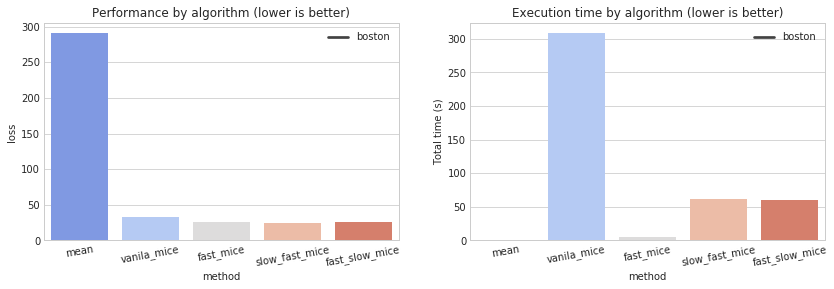

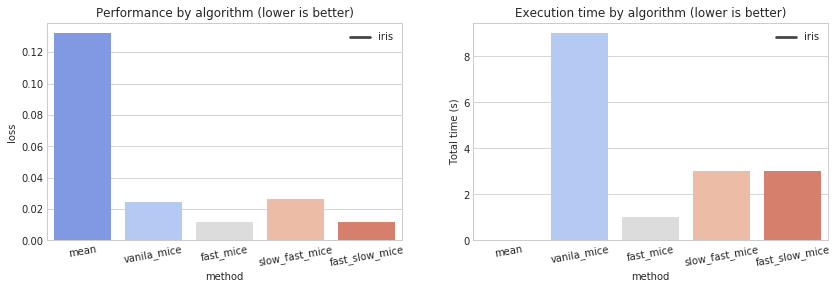

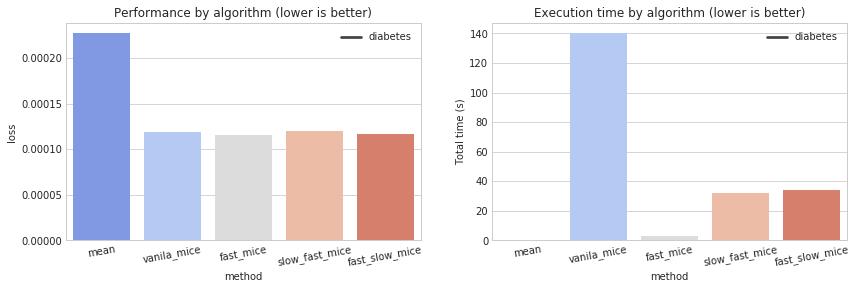

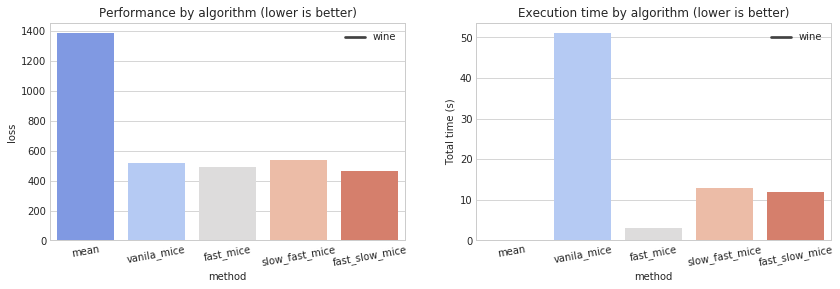

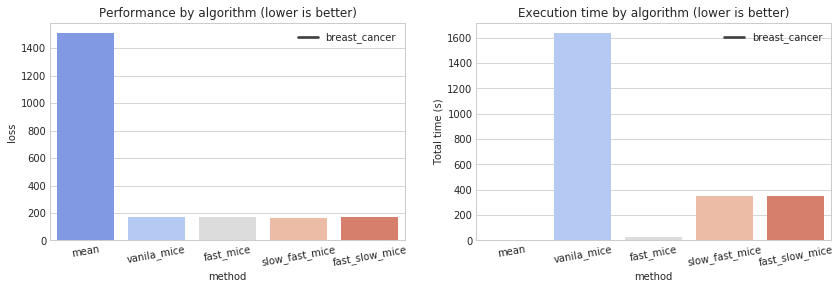

In [55]:
# Plot results by dataset
for dataset in results_by_dataset:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 4))
    g = sns.barplot(data=results_by_dataset[dataset], x='method', y='loss', ax = ax1, palette='coolwarm')
    sns.barplot(data=results_by_dataset[dataset], x='method', y='total_time', ax = ax2, palette='coolwarm')
    ax1.set_title("Performance by algorithm (lower is better)")
    ax2.set_title("Execution time by algorithm (lower is better)")
    ax2.set_ylabel('Total time (s)')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=10)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=10)
    ax1.legend([dataset])
    ax2.legend([dataset])
    
    # save img to disk
    # fig.savefig(f"benchmark_results_{dataset}_plot.png")  # uncomment to save the images

In [41]:
# Time comparison between the methods
df = pd.concat([results_by_dataset[dataset] for dataset in results_by_dataset], axis=0)
method_agg = df.groupby('method').sum().drop(index='mean')
method_agg['total_time'].max() / method_agg['total_time']

method
fast_mice         56.368421
fast_slow_mice     4.656522
slow_fast_mice     4.646421
vanila_mice        1.000000
Name: total_time, dtype: float64

In [53]:
# Time comparison between the methods
df = pd.concat([results_by_dataset[dataset] for dataset in results_by_dataset], axis=0)
method_agg = df.groupby('method').sum().drop(index='mean')
print(f"Fast MICE is {round(method_agg.iloc[1,1] / method_agg.iloc[0,1])}x faster than Fast-Slow / Slow-Fast MICE.")
print(f"Fast MICE is {round(method_agg.iloc[3,1] / method_agg.iloc[0,1])}x faster than Vanila MICE.")
print(f"Fast-Slow / Slow-Fast MICE are {round(method_agg.iloc[3,1] / method_agg.iloc[1,1])}x faster than Vanila MICE.")

Fast MICE is 12.0x faster than Fast-Slow / Slow-Fast MICE.
Fast MICE is 56.0x faster than Vanila MICE.
Fast-Slow / Slow-Fast MICE are 5.0x faster than Vanila MICE.


### Conclusion

MICE provides a good way to impute values on data with Missing Completely At Random (MCAR) values when compared with mean / mode imputation. From the four implementations of the MICE algorithm (Vanila, Fast, Slow-Fast and Fast-Slow MICE), we can see from the figures above that there isn't a significant difference in performance between these methods on the datasets used for the benchmark. 

However, the fitting time is substancial different between them, where **Fast MICE** was the fastest method, performing, on average, 12x faster than the **Slow-Fast** and **Fast-Slow** methods and 56x faster than the **Vanila MICE** for essencially the same performance.